# This is a first notebook doing a sentiment analysis on the first 100k entries in the Yelp database.

This notebook closely follows the instructions given by **Natashsha Selvaraj** on [medium](https://medium.com/towards-data-science/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6)

In [70]:
# importing all needed libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42


In [2]:
# function to load only a part of the json file into a pandas dataframe

def get_df(fn, limit=None):
    json_lines = []
    line_nr = 1
    with open(fn) as f:
        for line in f:
            if limit and line_nr > limit:
                break
            json_line = json.loads(line)
            json_lines.append(json_line)
            line_nr += 1
    df = pd.DataFrame(json_lines)
    return df

In [3]:
# load the first 100k lines of the review file into a dataframe

dfr = get_df('../data/yelp_dataset/yelp_academic_dataset_review.json', 100000)
dfr

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
99995,pAEbIxvr6ebx2bHc1XvguA,SMH5CeiLvKx61lKwtLZ_PA,lV0k3BnslFRkuWD_kbKd0Q,4.0,0,0,0,Came here for lunch with a group. They were bu...,2018-05-30 22:28:56
99996,xH1AoE-4nf2ECGQJRjO4_g,2clTdtp-BjphxLjN83CpUA,G0xz3kyRhRi6oZl7KfR0pA,1.0,1,0,0,The equipment is so old and so felty! I just u...,2015-04-05 23:31:52
99997,GatIbXTz-WDru5emONUSIg,MRrN6DH3QGCFcDv5RENYVg,C4lZdhasjZVQyDlOiXY1sA,4.0,0,0,0,This is one of my favorite Mexican restaurants...,2016-06-04 00:59:15
99998,6NfkodAdhvI89xONXuBC3A,rnNQzeKJbvqVCsYsL10mkQ,dChRGpit9fM_kZK5pafNyA,2.0,0,0,0,Came here for brunch - had an omlette ($19 + t...,2018-06-11 12:45:08


## First we want to have a look at the distribution of the star rating

In [11]:
#plot the graph of the ratings

fig = px.histogram(dfr, x='stars')
fig.update_layout(title_text='Stars Rating', width=700, height=300)
fig.show()

We can see, that the dataset ist strongly skewed towards positive reviews.

## Next step is to generate wordclouds

First we will start with all reviews and then split the data into positive and negative reviews and compare the corresponding clouds.

In [35]:
# initialize the stopword list:
stopwords = nltk.corpus.stopwords.words('english')

# update the stopwords after generating the first few clouds with non decisive words
additional_stopwords = ['one', 'go', 'also', 'would', 'get', 'got']
stopwords.extend(additional_stopwords)

# create a wordcloud using all the text in text
text = " ".join(text for text in dfr.text)

#remove the stopwords from the text
wordcloud = WordCloud(stopwords=stopwords).generate(text)

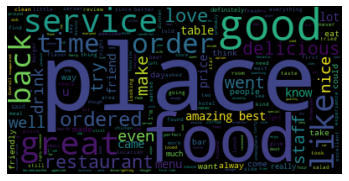

In [36]:
# plot the wordcloud

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It can be seen, that a big park of the reviews concern restaurants and bars (food, drink, ordered etc.)
It is also noticeable, that way more reviews are positive than negative, shown by good, great love amazing etc...

## Now we have to classify the reviews into positive and negative reviews

to do this, all reviews below 3 will be classified as negative and all reviews higher than 3 will be positive. As 3 is a neutral classification, we will drop these reviews

In [24]:
# remove all 3 stars reviews
# # assigning the positive (+1) and negative (-1) classes to reviews above or below 3 stars in a new feature called sentiment

dfr_sentiment = dfr[dfr['stars'] != 3]
dfr_sentiment['sentiment'] = dfr_sentiment['stars'].apply(lambda rating : +1 if rating > 3 else -1)

# look at the head of the new dataframe showing the new feature

dfr_sentiment.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,-1
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1


Building WordClouds for the positive and negative reviews
Therefore we have to split the dataframe in a positive and a negative dataframe

In [32]:
# split df in positive and negative df

df_pos = dfr_sentiment[dfr_sentiment['sentiment'] == 1]
df_neg = dfr_sentiment[dfr_sentiment['sentiment'] == -1]

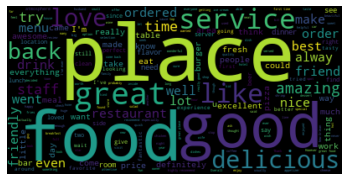

In [37]:
# generate the positive wordclouds and plot them

pos = " ".join(text for text in df_pos.text)
wordcloud_pos = WordCloud(stopwords=stopwords).generate(pos)

plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

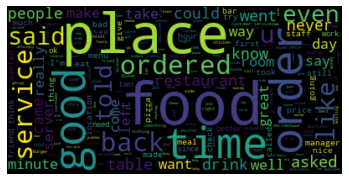

In [38]:
# generate the negative wordclouds and plot them

neg = " ".join(text for text in df_neg.text)
wordcloud_neg = WordCloud(stopwords=stopwords).generate(neg)

plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

These Wordclouds don't really give any impression of the rating of the review

## Having done a first set of EDA, we can now train our first sentiment analysis model

Before Vectorizing the Words, we have to do some Data Cleaning.

We will remove all punctuation

In [49]:
# define a list with all symbols to be removed
punctuation = ['?', '.', ':', ':', '!', '"', '(', ')', '-', '$', ',', '+', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

# function to remove these symbols
def remove_punctuation(text):    
    cleaned_text = "".join(u for u in text if u not in punctuation)
    return cleaned_text


In [54]:
# apply function to df
dfr_sentiment['text'] = dfr_sentiment['text'].apply(remove_punctuation)


Now we have to split the data in a test and a training part

In [55]:
# split data into feature and target 
X = dfr_sentiment['text']
y = dfr_sentiment['sentiment']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)

Now we have to Vectorize the Words. 
We will use the Tfidf Vectorizer

In [57]:
# initialize vectorizer
vectorizer = TfidfVectorizer()

# fit and transform the text
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Now we can train the model

In [58]:
# initialize the model
logreg = LogisticRegression()

# fit the model
logreg.fit(X_train, y_train)

LogisticRegression()

In [59]:
# make predictions
y_pred = logreg.predict(X_test)

<AxesSubplot:>

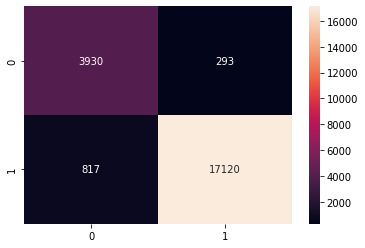

In [65]:
# test the model
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

In [66]:
# show the classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.83      0.93      0.88      4223
           1       0.98      0.95      0.97     17937

    accuracy                           0.95     22160
   macro avg       0.91      0.94      0.92     22160
weighted avg       0.95      0.95      0.95     22160



### This model has an accuracy of 95 % to correctly predict the sentiment of a review

## Now we can try the same, but to get the model to predict the star rating.

we will follow the same preprocessing steps, but keep all reviews and make stars the target

We have to choose a different Classifier: We will take MultinomialNB

In [71]:
# remove punctuation from the text in the initial df
dfr['text'] = dfr['text'].apply(remove_punctuation)

# split data into feature and target 
X = dfr['text']
y = dfr['stars']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)

# fit and apply the vectorizer
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# initialize the Classifier
MNB = MultinomialNB()

# fit the model
MNB.fit(X_train, y_train)

# make predictions
y_pred = MNB.predict(X_test)

<AxesSubplot:>

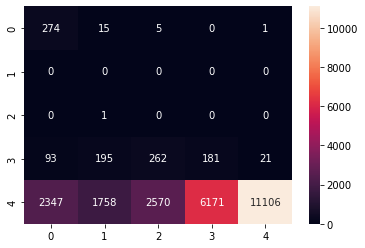

In [72]:
# test the model
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

In [73]:
# show the classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.10      0.93      0.18       295
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         1
         4.0       0.03      0.24      0.05       752
         5.0       1.00      0.46      0.63     23952

    accuracy                           0.46     25000
   macro avg       0.23      0.33      0.17     25000
weighted avg       0.96      0.46      0.61     25000



## As we can see, this model is really bad, becaus we have way to many positive reviews. 
we will have to look at this problem